In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os

# 设置数据路径（适配 Jupyter Notebook）
script_dir = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(script_dir))
data_dir = os.path.join(parent_dir, "UCB_results")
print("模拟结果的位置:", data_dir)

模拟结果的位置: e:\VS code project\UCB_results


In [18]:
# 定义类别
CLASS = "Politics & International"  # 可修改为 Culture & Lifestyle, Economy & Business, Environment & Safety, Politics & International

# 定义数据集配置
methods = [
    {'name': 'MA-UCB', 'csv': f'MA_UCB_simulate_results_{CLASS}.csv', 'column': 'mean_accuracy', 'color': "#58a9e4"},  # 蓝色
    {'name': 'AP-UCB(Maximum)', 'csv': f'AP_UCB_simulation_results_{CLASS}.csv', 'column': 'mean_accuracy_max', 'color': "#ec9e59"},  # 橙色
    {'name': 'AP-UCB(Minimum)', 'csv': f'AP_UCB_simulation_results_{CLASS}.csv', 'column': 'mean_accuracy_min', 'color': "#5be95b"},  # 绿色
    {'name': 'AP-UCB(Median)', 'csv': f'AP_UCB_simulation_results_{CLASS}.csv', 'column': 'mean_accuracy_mean', 'color': "#b26df3"}  # 紫色
]

In [19]:
# 加载和验证数据集
def load_and_validate_data(methods, data_dir):
    datasets = []
    try:
        for method in methods:
            csv_path = os.path.join(data_dir, method['csv'])
            if not os.path.exists(csv_path):
                raise FileNotFoundError(f"CSV file not found: {csv_path}")
            df = pd.read_csv(csv_path)
            
            # 确保 T 列为数值型
            df['T'] = pd.to_numeric(df['T'], errors='coerce')
            if df['T'].isnull().any():
                raise ValueError(f"Invalid T values in {method['name']} dataset")
            
            def parse_accuracy(x):
                try:
                    return float(ast.literal_eval(x)) if isinstance(x, str) else float(x)
                except ValueError:
                    print(f"Failed to parse {method['column']} {x} in {method['name']} dataset")
                    raise
            
            try:
                df[method['column']] = df[method['column']].apply(parse_accuracy)
            except ValueError as e:
                print(f"Error parsing {method['column']} in {method['name']} dataset: {e}")
                raise
            
            datasets.append({
                'name': method['name'],
                'df': df,
                'column': method['column'],
                'color': method['color']
            })
        print("All datasets loaded successfully")
        return datasets
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        raise

datasets = load_and_validate_data(methods, data_dir)

All datasets loaded successfully


In [20]:
# 定义 T 值和柱状图参数
T_values = [200, 400, 600, 800, 1000, 1200, 1500, 1800]
T_indices = [i + 0.6 for i in range(len(T_values))]  # T对应的区域的中心位置
bar_width = 0.2
offset = [-0.3, -0.1, 0.1, 0.3]  # 四个柱状体的相对位置

 MA-UCB:
 0    0.431814
1    0.469815
2    0.495583
3    0.510657
4    0.524643
5    0.551535
6    0.557591
7    0.583669
Name: mean_accuracy, dtype: float64
 AP-UCB(Maximum):
 0    0.406945
1    0.431616
2    0.441719
3    0.464509
4    0.476108
5    0.486274
6    0.504745
7    0.521162
Name: mean_accuracy_max, dtype: float64
 AP-UCB(Minimum):
 0    0.460506
1    0.480573
2    0.495345
3    0.541326
4    0.531973
5    0.554917
6    0.543003
7    0.544556
Name: mean_accuracy_min, dtype: float64
 AP-UCB(Median):
 0    0.434389
1    0.451326
2    0.482786
3    0.490742
4    0.500263
5    0.512387
6    0.534454
7    0.544153
Name: mean_accuracy_mean, dtype: float64


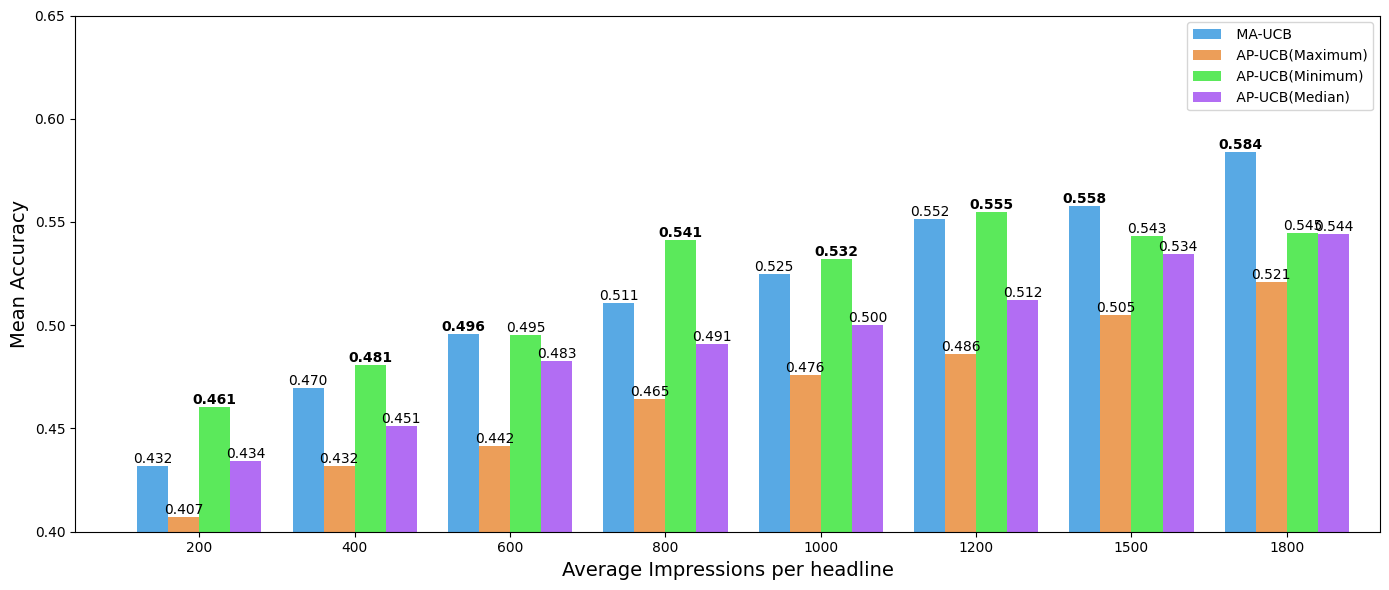

In [21]:
def plot_accuracy_bar(datasets, T_values, T_indices, bar_width, offset, CLASS):
    plt.figure(figsize=(14, 6), dpi=100)  # 12 英寸宽，DPI=100 确保间距
    
    # 收集所有准确率，用于动态设置 Y 轴范围
    all_accuracies = []
    for i, dataset in enumerate(datasets):
        df = dataset['df']
        column = dataset['column']
        color = dataset['color']
        label = f" {dataset['name']}"
        
        # 收集准确率
        all_accuracies.extend(df[column].tolist())
        
        # 打印准确率
        print(f"{label}:\n", df[column])
        
        # 绘制分组柱状图
        x_positions = [T_indices[T_values.index(t)] + offset[i] for t in df['T']]
        bars = plt.bar(x_positions, df[column], width=bar_width, color=color, label=label)
    
    # 标注数值并加粗最大值
    for t_idx, t in enumerate(T_values):
        accuracies = []
        for dataset in datasets:
            df = dataset['df']
            value = df[df['T'] == t][dataset['column']].iloc[0] if t in df['T'].values else 0.0
            accuracies.append((value, dataset['name'], dataset['color']))
        
        # 找到最大值
        max_accuracy = max(accuracies, key=lambda x: x[0])[0] if accuracies else 0.0
        
        # 标注数值
        for i, (value, name, color) in enumerate(accuracies):
            x_pos = t_idx + 0.6 + offset[i]
            fontweight = 'bold' if value == max_accuracy else 'normal'
            plt.text(x_pos, value, f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight=fontweight)
    
    # 动态设置 Y 轴范围
    if all_accuracies:
        y_min = min(all_accuracies)
        y_max = max(all_accuracies)
        y_range = y_max - y_min
        y_margin = y_range * 0.2 if y_range > 0 else 0.1
        if CLASS == 'Environment & Safety':
            plt.ylim(0.37, 0.62)
        else:
            plt.ylim(0.40, 0.65)
    else:
        print("Warning: No accuracy values calculated, using default Y-axis range")
        plt.ylim(0, 1)
    
    # 设置图表样式
    plt.xlabel(r'Average Impressions per headline', fontsize=14)
    plt.ylabel('Mean Accuracy', fontsize=14)
    plt.xticks(T_indices, T_values)  # x 轴显示离散 T 值
    plt.xlim(-0.2, len(T_values) + 0.2)  # 调整 x 轴范围以适配离散区域
    plt.legend(loc='best', ncol=1, fontsize=10)
    plt.tight_layout()
    plt.show()

# 调用柱状图可视化
plot_accuracy_bar(datasets, T_values, T_indices, bar_width, offset, CLASS)